In [1]:
%autoreload 2


In [3]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [34]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl.gz'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


2023-08-29 00:20:10 - src.ast_utils - INFO     - Loading from cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz
2023-08-29 00:20:11 - src.ast_utils - INFO     - Finished loading cache file: /misc/vlgscratch4/LakeGroup/guy/game_generation_cache/interactive-beta-cache.pkl.gz


98 6272 64.0 100352 1024.0


In [5]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl.gz']


,Index,src_file,game_name,domain_name,original_game_name,real,variables_defined_all,variables_defined_incorrect_count,variables_used_all,variables_used_incorrect_count,...,ast_ngram_constraints_n_4_score,ast_ngram_constraints_n_5_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,0.0,1,0.0,...,0.333014,0.292747,0.759011,0.830095,0.8811,0.921841,0.887935,0.550337,0.437055,0.409231
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,0.0,1,0.0,...,0.459693,0.443844,0.759011,0.830095,0.8811,0.921841,0.078288,0.042963,0.047686,0.068369
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,0.0,1,0.0,...,0.807747,0.824131,0.000000,0.000000,0.0000,0.000000,0.692285,0.448698,0.371473,0.360291
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,0.0,1,0.0,...,0.556012,0.543127,0.000000,0.000000,0.0000,0.000000,0.887935,0.550337,0.437055,0.409231
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,0.0,1,0.0,...,0.443389,0.420543,0.000000,0.000000,0.0000,0.000000,0.124413,0.062983,0.053335,0.063983


In [27]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID, LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
# model_date_id = LATEST_SPECIFIC_OBJECTS_FITNESS_FUNCTION_DATE_ID
# model_date_id = 'full_features_no_in_data_all_2023_08_09'
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



353


In [7]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [8]:
real_game_scores = full_tensor_scores[:, 0]

print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
print(f'20th percentile negative energy: {torch.quantile(negatives_scores.ravel(), 0.2)}')

Real game scores: -7.5101 ± 0.3134, min = -8.0367, max = -5.9038
20th percentile negative energy: -7.2298583984375


In [9]:
data_df.groupby('real')[[c for c in data_df.columns if 'in_data' in c]].mean()

,predicate_found_in_data_setup_all,predicate_found_in_data_setup_prop,predicate_found_in_data_constraints_all,predicate_found_in_data_constraints_prop
real,,,,
0,0.448342,0.459351,0.768076,0.950229
1,0.469388,0.469388,0.948980,0.994590


In [10]:
data_df.groupby('real')[[c for c in data_df.columns if 'starts_and_ends_once' in c]].describe()

starts_and_ends_once                                             
                    count      mean       std  min  25%  50%  75%  max
real                                                                  
0                100352.0  0.857932  0.343590  0.0  1.0  1.0  1.0  1.0
1                    98.0  0.877551  0.329489  0.0  1.0  1.0  1.0  1.0

## Histogram the weights to get a sense of what we're dealing with

Weights mean: 0.0473, std: 0.4185, bias: 0.0100


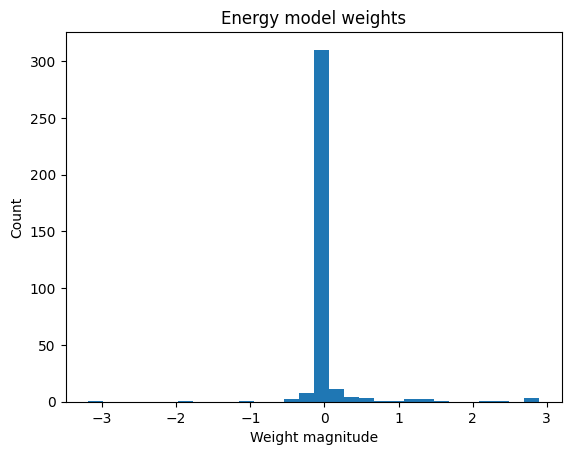

In [11]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [12]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (141, 39.94%) of the weights have magnitude < 0.0006
Approximately 25.0% (169, 47.88%) of the weights have magnitude < 0.0013
Approximately 50.0% (194, 54.96%) of the weights have magnitude < 0.0019
Approximately 75.0% (265, 75.07%) of the weights have magnitude < 0.0070
Approximately 90.0% (318, 90.08%) of the weights have magnitude < 0.1702
Approximately 95.0% (336, 95.18%) of the weights have magnitude < 0.4915
Approximately 99.0% (350, 99.15%) of the weights have magnitude < 2.7864


## Print the top K features most and least predictive of real games

In [13]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. variables_used_all (-3.1867)
2. predicate_found_in_data_constraints_prop (-1.7889)
3. preferences_used_all (-1.0152)
4. variables_defined_all (-0.4814)
5. setup_quantified_objects_used (-0.3716)
6. max_depth_constraints_1 (-0.3366)
7. ast_ngram_constraints_n_5_score (-0.3272)
8. predicate_under_modal_hold_agent_holds (-0.2840)
9. on_arg_types_furniture_large_objects_setup (-0.2367)
10. max_quantification_count_setup_0 (-0.2321)
11. setup_objects_used (-0.2218)
12. in_arg_types_receptacles_balls_constraints (-0.1966)
13. pref_forall_pref_forall_correct_arity_correct (-0.1800)
14. predicate_under_modal_at_end_in (-0.1325)
15. in_arg_types_building_blocks_constraints (-0.1275)
16. node_count_setup_0 (-0.1044)
17. no_adjacent_same_modal (-0.0757)
18. max_number_variables_types_quantified_variables_1 (-0.0743)
19. num_preferences_defined_1 (-0.0308)
20. predicate_under_modal_while_hold_agent_holds (-0.0274)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_used_incorrect (2.8966)
2. repeated_variables_found (2.8105)
3. pref_forall_pref_forall_correct_types_incorrect (2.7859)
4. in_arg_types_other_constraints (2.2964)
5. disjoint_seq_funcs_found (2.1838)
6. pref_forall_pref_forall_correct_arity_incorrect (1.6516)
7. redundant_expression_found (1.4314)
8. two_number_operation_found (1.4095)
9. distance_arg_types_other_constraints (1.2306)
10. nested_logicals_found (1.1203)
11. adjacent_arg_types_other_constraints (1.0004)
12. in_motion_arg_types_room_features_constraints (0.8506)
13. agent_holds_arg_types_room_features_constraints (0.6557)
14. in_motion_arg_types_receptacles_constraints (0.5350)
15. in_motion_arg_types_other_constraints (0.4912)
16. on_arg_types_other_constraints (0.4322)
17. agent_holds_arg_types_other_setup (0.3524)
18. agent_holds_arg_types_other_constraints (0.3462)
19. in_motion_arg_types_other_setup (0.2656)
20. agent_holds_arg_types_furniture_constraints (0.2579)

In [15]:
abs_weights = weights.abs()
sorted_feature_names = [t[1] for t in sorted([(abs_weights[i], feature_columns[i]) for i in range(len(feature_columns))], key=lambda x: x[0], reverse=True)]

for category, features in FEATURE_CATEGORIES.items():
    mean_abs_weight = np.mean([abs_weights[feature_columns.index(feature)] for feature in features])
    sum_abs_weight = np.sum([abs_weights[feature_columns.index(feature)] for feature in features])
    mean_sorted_index = np.mean([sorted_feature_names.index(feature) for feature in features])
    prefix = f'For category {category} with {len(features)} features'
    print(f'{prefix:54} | mean abs weight is {mean_abs_weight:5.2f} | sum abs weight is {sum_abs_weight:6.2f} | mean sorted index is {mean_sorted_index:6.2f}')
    


For category grammar_context with 12 features          | mean abs weight is  0.63 | sum abs weight is   7.52 | mean sorted index is 181.25
For category ngram_and_data_based with 7 features      | mean abs weight is  0.31 | sum abs weight is   2.14 | mean sorted index is  96.43
For category counting with 101 features                | mean abs weight is  0.01 | sum abs weight is   1.51 | mean sorted index is 170.04
For category forall with 15 features                   | mean abs weight is  0.50 | sum abs weight is   7.55 | mean sorted index is 170.27
For category predicate_under_modal with 50 features    | mean abs weight is  0.02 | sum abs weight is   0.85 | mean sorted index is 210.34


ValueError: 'agent_holds_arg_types_agent_constraints' is not in list

In [ ]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if c.startswith('max_width_constraints')]

In [ ]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'setup' in c]

In [ ]:
data_df.groupby('real').variables_used_incorrect_count.describe()

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'once' in c]

In [ ]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

In [ ]:
threshold = 5.0

fs = [c for i, c in enumerate(feature_columns) if 
      (weights[i].abs() < threshold) and ('arg_types' in c  or c.startswith('compositionality') or c.startswith('predicate_under_'))]

len(fs)

In [ ]:
p = 0.1
s = data_df[data_df.real == 1][fs].mean().sort_values(ascending=False)
print(len(s[s > p]))
s[s > p].index

## Plot a histogram of the values for each of the and bottom K features

In [16]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

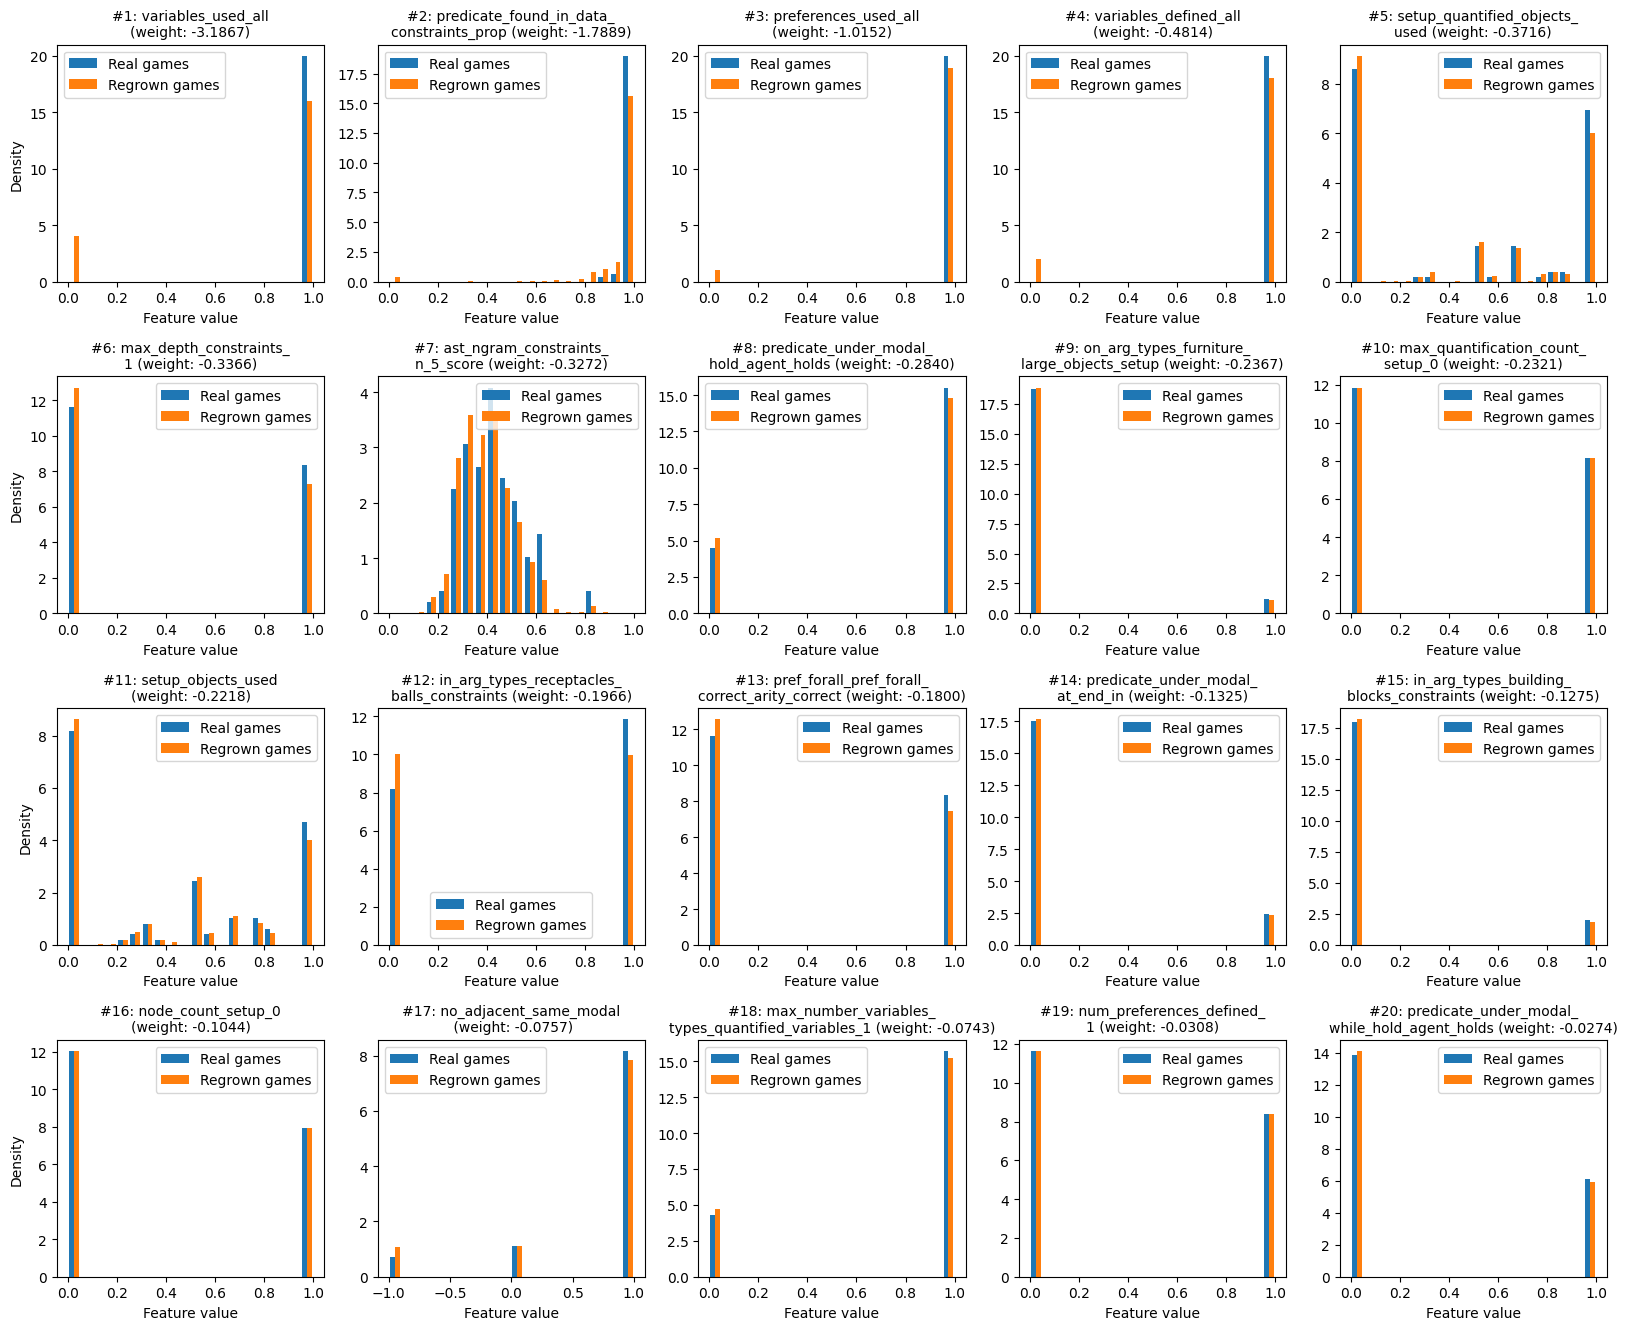

In [17]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

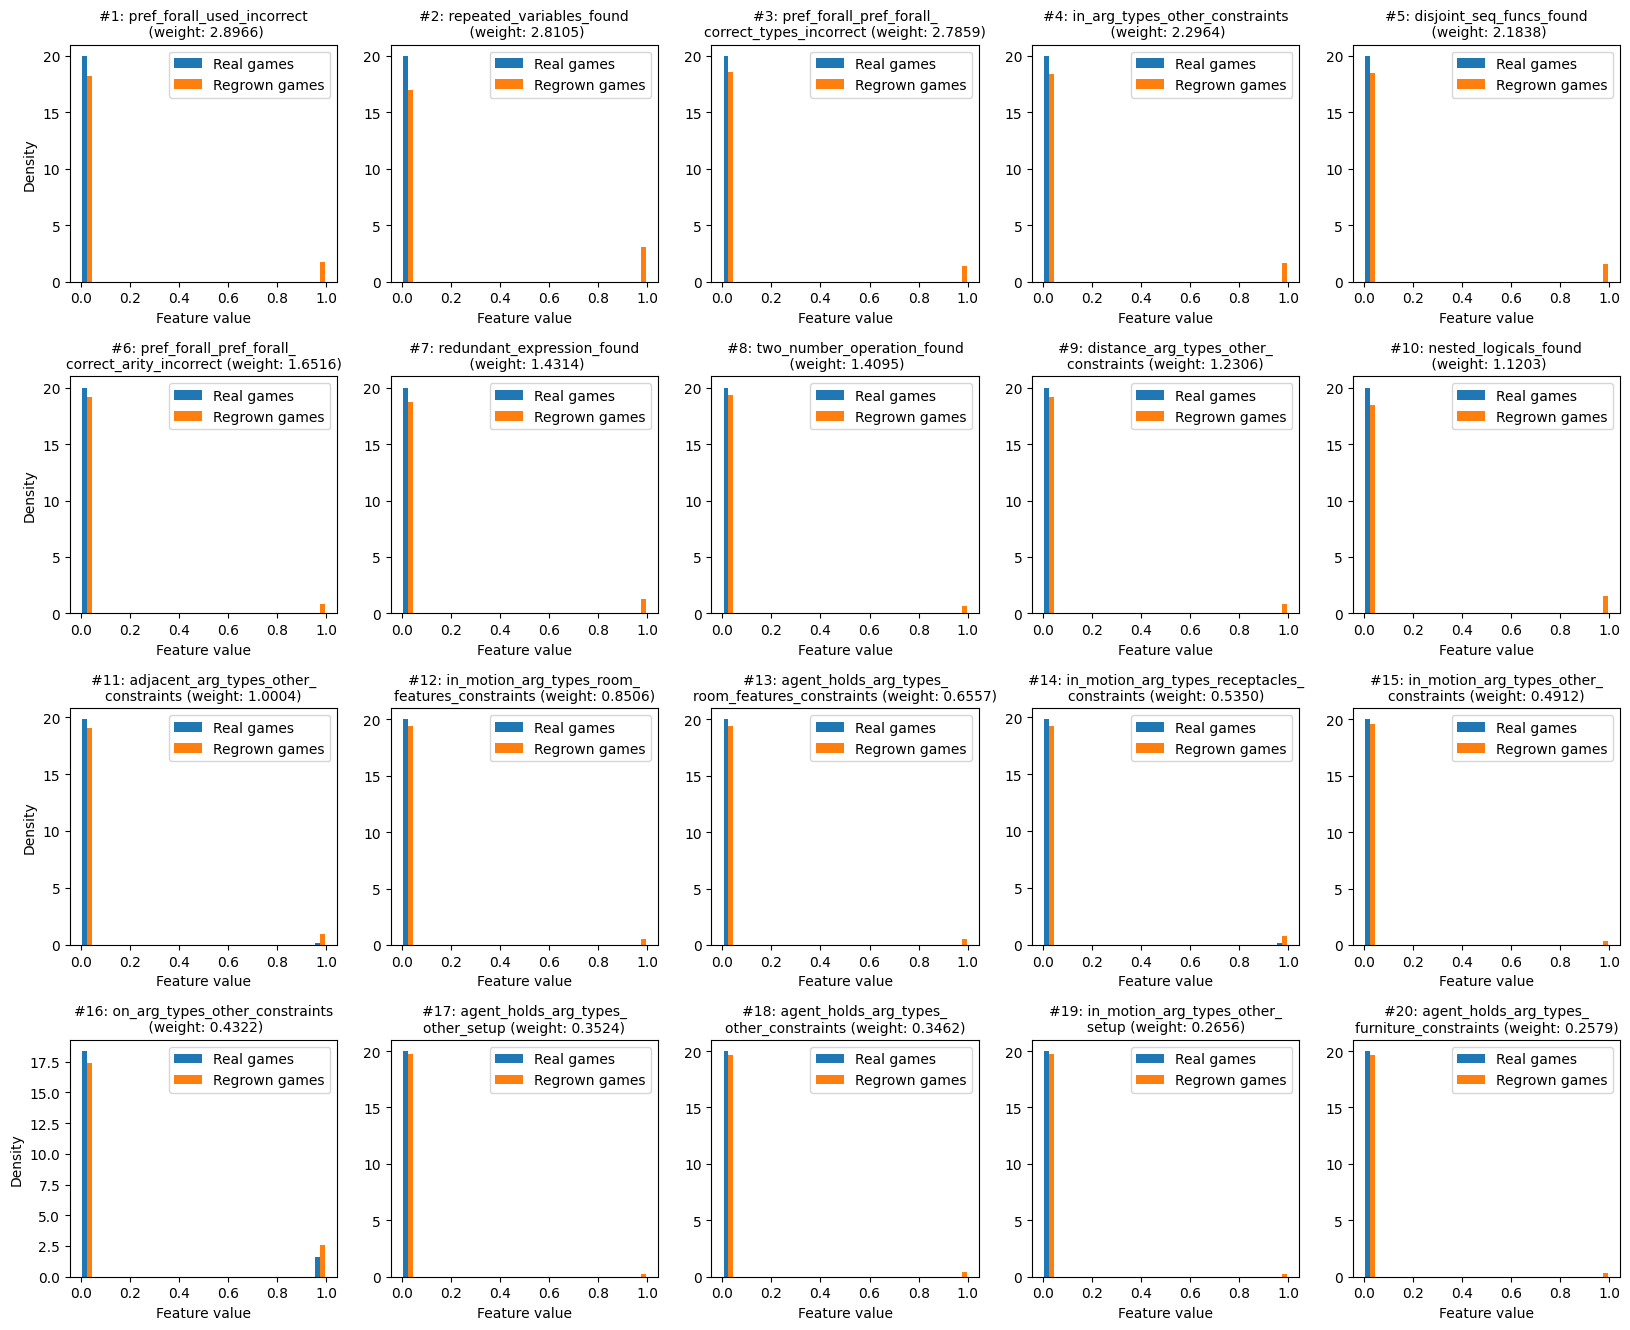

In [18]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [19]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

Real game scores: -7.5101 ± 0.3134, min = -8.0367, max = -5.9038


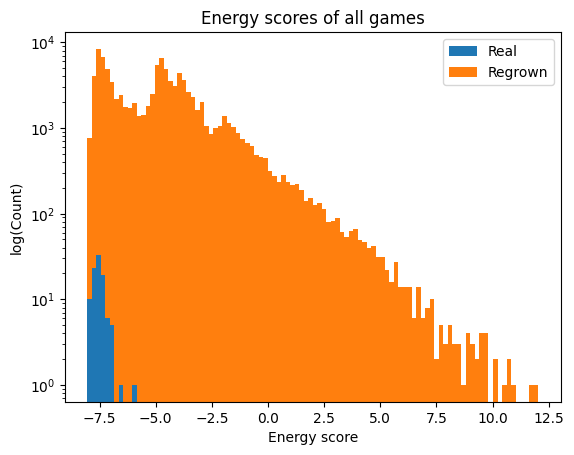

In [20]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [21]:
full_cv_sweep_outputs = utils.load_data(model_date_id, 'data/fitness_cv', 'fitness_sweep')
print(full_cv_sweep_outputs.keys())

dict_keys(['cv', 'train_tensor', 'test_tensor', 'results', 'feature_columns'])


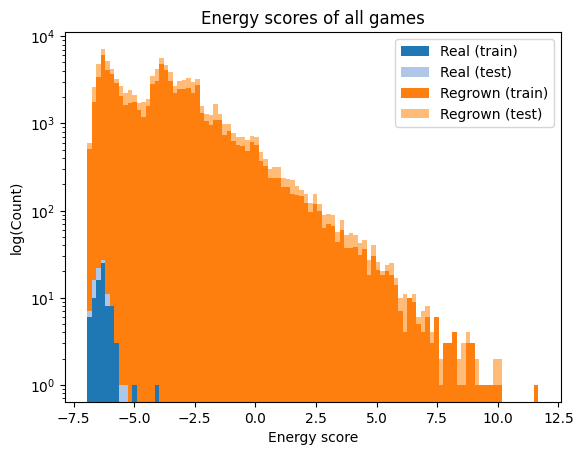

In [22]:
utils.plot_energy_histogram(
    full_cv_sweep_outputs['cv'], 
    full_cv_sweep_outputs['train_tensor'], 
    full_cv_sweep_outputs['test_tensor'])

In [23]:
negatives_scores = full_tensor_scores[:, 1:]
torch.quantile(negatives_scores.ravel(), torch.linspace(0, 1, 11))
torch.quantile(negatives_scores.ravel(), 0.2)

tensor(-7.2299)

In [24]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [25]:
torch.topk(score_diffs.ravel(), 10, largest=False)

torch.return_types.topk(
values=tensor([-1.7789, -1.7083, -1.0145, -1.0115, -1.0115, -1.0041, -1.0027, -1.0026,
        -0.9975, -0.9973]),
indices=tensor([62963, 62651, 62933, 62567, 63068, 63030, 62938, 63439, 63195, 62718]))

In [33]:
idxs = (full_tensor[61, 0] - full_tensor[61, 499]).nonzero().squeeze()
[feature_columns[idx] for idx in idxs]

['predicate_found_in_data_constraints_prop',
 'predicate_under_modal_while_hold_on',
 'predicate_under_modal_while_hold_agent_holds',
 'in_motion_arg_types_balls_constraints',
 'in_motion_arg_types_furniture_constraints',
 'on_arg_types_large_objects_balls_constraints',
 'ast_ngram_full_n_5_score',
 'ast_ngram_constraints_n_5_score']

In [35]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

Original game index: 61 | Negative game row: 61 | Negative game col: 499


### Energy of real game: -5.904 | Energy of regrown game: -7.683 | Difference: -1.779

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                                   | Features decreasing energy (= more real)                                              |
|------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| predicate_under_modal_while_hold_agent_holds: **0.027** = (1.000 => 0.000) * -0.027                        | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000           |
| predicate_under_modal_once_agent_holds: **0.017** = (1.000 => 0.000) * -0.017                              | on_arg_types_other_constraints: **-0.432** = (1.000 => 0.000) * 0.432                 |
| in_motion_arg_types_furniture_constraints: **0.009** = (0.000 => 1.000) * 0.009                            | predicate_found_in_data_constraints_prop: **-0.224** = (0.875 => 1.000) * -1.789      |
| predicate_under_modal_while_hold_touch: **0.009** = (1.000 => 0.000) * -0.009                              | setup_objects_used: **-0.074** = (0.667 => 1.000) * -0.222                            |
| predicate_under_modal_once_on: **0.008** = (1.000 => 0.000) * -0.008                                       | mean_depth_constraints_2: **-0.064** = (1.000 => 0.000) * 0.064                       |
| mean_depth_constraints_1: **0.005** = (0.000 => 1.000) * 0.005                                             | ast_ngram_constraints_n_5_score: **-0.054** = (0.299 => 0.463) * -0.327               |
| touch_arg_types_balls_large_objects_constraints: **0.005** = (1.000 => 0.000) * -0.005                     | predicate_under_modal_hold_in_motion: **-0.016** = (0.000 => 1.000) * -0.016          |
| starts_and_ends_once: **0.004** = (1.000 => 0.000) * -0.004                                                | node_count_constraints_2: **-0.008** = (1.000 => 0.000) * 0.008                       |
| node_count_constraints_1: **0.004** = (0.000 => 1.000) * 0.004                                             | agent_holds_arg_types_balls_constraints: **-0.003** = (1.000 => 0.000) * 0.003        |
| object_orientation_arg_types_large_objects_orientations_constraints: **0.003** = (1.000 => 0.000) * -0.003 | in_motion_arg_types_large_objects_constraints: **-0.002** = (0.000 => 1.000) * -0.002 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-499-nd-8-rd-13-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 187


### Energy of real game: -5.904 | Energy of regrown game: -7.612 | Difference: -1.708

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                              | Features decreasing energy (= more real)                                         |
|---------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| predicate_under_modal_once_on: **0.008** = (1.000 => 0.000) * -0.008                  | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000      |
| mean_depth_constraints_1: **0.005** = (0.000 => 1.000) * 0.005                        | on_arg_types_other_constraints: **-0.432** = (1.000 => 0.000) * 0.432            |
| node_count_constraints_1: **0.004** = (0.000 => 1.000) * 0.004                        | predicate_found_in_data_constraints_prop: **-0.224** = (0.875 => 1.000) * -1.789 |
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003            | mean_depth_constraints_2: **-0.064** = (1.000 => 0.000) * 0.064                  |
| agent_holds_arg_types_large_objects_constraints: **0.002** = (0.000 => 1.000) * 0.002 | node_count_constraints_2: **-0.008** = (1.000 => 0.000) * 0.008                  |
|                                                                                       | ast_ngram_constraints_n_5_score: **-0.003** = (0.299 => 0.307) * -0.327          |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-187-nd-13-rd-7-rs-constraints-sk-prior
,,,,>,12) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 469


### Energy of real game: -5.904 | Energy of regrown game: -6.918 | Difference: -1.014

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                     |
|----------------------------------------------------------------------------|------------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000  |
|                                                                            | predicate_under_modal_once_in_motion: **-0.013** = (0.000 => 1.000) * -0.013 |
|                                                                            | ast_ngram_constraints_n_5_score: **-0.004** = (0.299 => 0.312) * -0.327      |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-469-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,12) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 604


### Energy of real game: -5.904 | Energy of regrown game: -6.915 | Difference: -1.011

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                              |
|----------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000           |
|                                                                            | predicate_under_modal_once_in_motion: **-0.013** = (0.000 => 1.000) * -0.013          |
|                                                                            | in_motion_arg_types_large_objects_constraints: **-0.002** = (0.000 => 1.000) * -0.002 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-604-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 103


### Energy of real game: -5.904 | Energy of regrown game: -6.915 | Difference: -1.011

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                              |
|----------------------------------------------------------------------------|---------------------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000           |
|                                                                            | predicate_under_modal_once_in_motion: **-0.013** = (0.000 => 1.000) * -0.013          |
|                                                                            | in_motion_arg_types_large_objects_constraints: **-0.002** = (0.000 => 1.000) * -0.002 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-103-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,12) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 566


### Energy of real game: -5.904 | Energy of regrown game: -6.908 | Difference: -1.004

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)   | Features decreasing energy (= more real)                                                   |
|--------------------------------------------|--------------------------------------------------------------------------------------------|
|                                            | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000                |
|                                            | ast_ngram_constraints_n_5_score: **-0.002** = (0.299 => 0.306) * -0.327                    |
|                                            | adjacent_arg_types_agent_large_objects_constraints: **-0.001** = (0.000 => 1.000) * -0.001 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-566-nd-19-rd-1-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 474


### Energy of real game: -5.904 | Energy of regrown game: -6.906 | Difference: -1.003

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                             |
|----------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000          |
|                                                                            | ast_ngram_constraints_n_5_score: **-0.003** = (0.299 => 0.309) * -0.327              |
|                                                                            | on_arg_types_large_objects_balls_constraints: **-0.002** = (0.000 => 1.000) * -0.002 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-474-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 975


### Energy of real game: -5.904 | Energy of regrown game: -6.906 | Difference: -1.003

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                    |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |
|                                                                            | ast_ngram_constraints_n_5_score: **-0.005** = (0.299 => 0.316) * -0.327     |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-975-nd-15-rd-5-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 731


### Energy of real game: -5.904 | Energy of regrown game: -6.901 | Difference: -0.997

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                               | Features decreasing energy (= more real)                                    |
|------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| ast_ngram_constraints_n_5_score: **0.003** = (0.299 => 0.291) * -0.327 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-731-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 254


### Energy of real game: -5.904 | Energy of regrown game: -6.901 | Difference: -0.997

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                               | Features decreasing energy (= more real)                                    |
|------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| ast_ngram_constraints_n_5_score: **0.004** = (0.299 => 0.288) * -0.327 | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-254-nd-17-rd-3-rs-constraints-sk-prior
,,,,>,22) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 668


### Energy of real game: -5.904 | Energy of regrown game: -6.899 | Difference: -0.995

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                              | Features decreasing energy (= more real)                                    |
|---------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003            | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |
| agent_holds_arg_types_large_objects_constraints: **0.002** = (0.000 => 1.000) * 0.002 |                                                                             |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-668-nd-15-rd-5-rs-constraints-sk-prior
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 21


### Energy of real game: -5.904 | Energy of regrown game: -6.899 | Difference: -0.995

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                              | Features decreasing energy (= more real)                                    |
|---------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003            | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |
| agent_holds_arg_types_large_objects_constraints: **0.002** = (0.000 => 1.000) * 0.002 |                                                                             |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-21-nd-15-rd-5-rs-constraints-sk-prior1
,,,,>,2) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 803


### Energy of real game: -5.904 | Energy of regrown game: -6.894 | Difference: -0.990

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                    |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| ast_ngram_constraints_n_5_score: **0.008** = (0.299 => 0.276) * -0.327     | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 |                                                                             |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-803-nd-15-rd-5-rs-constraints-sk-prior
,,,,>,22) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 386


### Energy of real game: -5.904 | Energy of regrown game: -6.888 | Difference: -0.985

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                   | Features decreasing energy (= more real)                                    |
|----------------------------------------------------------------------------|-----------------------------------------------------------------------------|
| ast_ngram_constraints_n_5_score: **0.013** = (0.299 => 0.261) * -0.327     | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000 |
| predicate_under_modal_once_adjacent: **0.003** = (1.000 => 0.000) * -0.003 |                                                                             |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-386-nd-16-rd-4-rs-constraints-sk-prior
,,,,>,22) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 61 | Negative game row: 61 | Negative game col: 473


### Energy of real game: -5.904 | Energy of regrown game: -6.816 | Difference: -0.912

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                               | Features decreasing energy (= more real)                                         |
|----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| setup_quantified_objects_used: **0.372** = (1.000 => 0.000) * -0.372                   | adjacent_arg_types_other_constraints: **-1.000** = (1.000 => 0.000) * 1.000      |
| max_depth_constraints_1: **0.337** = (1.000 => 0.000) * -0.337                         | on_arg_types_other_constraints: **-0.432** = (1.000 => 0.000) * 0.432            |
| setup_objects_used: **0.148** = (0.667 => 0.000) * -0.222                              | predicate_found_in_data_constraints_prop: **-0.224** = (0.875 => 1.000) * -1.789 |
| no_adjacent_same_modal: **0.076** = (1.000 => 0.000) * -0.076                          | length_of_then_modals_3: **-0.157** = (1.000 => 0.000) * 0.157                   |
| predicate_under_modal_while_hold_agent_holds: **0.027** = (1.000 => 0.000) * -0.027    | mean_depth_constraints_2: **-0.064** = (1.000 => 0.000) * 0.064                  |
| predicate_under_modal_once_agent_holds: **0.017** = (1.000 => 0.000) * -0.017          | ast_ngram_constraints_n_5_score: **-0.047** = (0.299 => 0.444) * -0.327          |
| predicate_under_modal_while_hold_in_motion: **0.010** = (1.000 => 0.000) * -0.010      | node_count_constraints_2: **-0.008** = (1.000 => 0.000) * 0.008                  |
| predicate_under_modal_while_hold_touch: **0.009** = (1.000 => 0.000) * -0.009          | agent_holds_arg_types_balls_constraints: **-0.003** = (1.000 => 0.000) * 0.003   |
| predicate_under_modal_once_on: **0.008** = (1.000 => 0.000) * -0.008                   |                                                                                  |
| touch_arg_types_balls_large_objects_constraints: **0.005** = (1.000 => 0.000) * -0.005 |                                                                                  |

### Game Diffs

n,1,(define (game 5fa23c9b64b18a4067cc842e-72) (:domain many-objects-room-v1),n,1,(define (game 5fa23c9b64b18a4067cc842e-72-473-nd-7-rd-14-rs-constraints-sk-prior
,,,,>,12) (:domain many-objects-room-v1)
,2,(:setup,,2,(:setup
,3,(and,,3,(and
,4,(exists (?t - teddy_bear),,4,(exists (?t - teddy_bear)
,5,(game-optional,,5,(game-optional
,6,(and,,6,(and
,7,(on bed ?t),,7,(on bed ?t)
,8,(object_orientation ?t upright),,8,(object_orientation ?t upright)
,9,),,9,)
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 159


### Energy of real game: -6.547 | Energy of regrown game: -7.319 | Difference: -0.772

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                               |
|-----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| agent_holds_arg_types_balls_constraints: **0.003** = (0.000 => 1.000) * 0.003           | in_motion_arg_types_receptacles_constraints: **-0.535** = (1.000 => 0.000) * 0.535     |
| on_arg_types_furniture_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002 | agent_holds_arg_types_receptacles_constraints: **-0.222** = (1.000 => 0.000) * 0.222   |
| in_motion_arg_types_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002    | ast_ngram_constraints_n_5_score: **-0.016** = (0.232 => 0.282) * -0.327                |
|                                                                                         | on_arg_types_furniture_balls_constraints: **-0.003** = (0.000 => 1.000) * -0.003       |
|                                                                                         | agent_holds_arg_types_large_objects_constraints: **-0.002** = (1.000 => 0.000) * 0.002 |
|                                                                                         | in_motion_arg_types_balls_constraints: **-0.002** = (0.000 => 1.000) * -0.002          |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-159-nd-11-rd-4-rs-constraints-sk-prior
,,,,>,12) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - dodgeball_blue)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent))),,7,(once (and (agent_holds ?o) (adjacent desk agent)))
,8,(hold (and (not (agent_holds ?o)) (in_motion ?o))),,8,(hold (and (not (agent_holds ?o)) (in_motion ?o)))
,9,(once (and (not (in_motion ?o)) (on bed ?o))),,9,(once (and (not (in_motion ?o)) (on bed ?o)))
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 335


### Energy of real game: -6.547 | Energy of regrown game: -7.319 | Difference: -0.772

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                               |
|-----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| agent_holds_arg_types_balls_constraints: **0.003** = (0.000 => 1.000) * 0.003           | in_motion_arg_types_receptacles_constraints: **-0.535** = (1.000 => 0.000) * 0.535     |
| on_arg_types_furniture_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002 | agent_holds_arg_types_receptacles_constraints: **-0.222** = (1.000 => 0.000) * 0.222   |
| in_motion_arg_types_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002    | ast_ngram_constraints_n_5_score: **-0.016** = (0.232 => 0.282) * -0.327                |
|                                                                                         | on_arg_types_furniture_balls_constraints: **-0.003** = (0.000 => 1.000) * -0.003       |
|                                                                                         | agent_holds_arg_types_large_objects_constraints: **-0.002** = (1.000 => 0.000) * 0.002 |
|                                                                                         | in_motion_arg_types_balls_constraints: **-0.002** = (0.000 => 1.000) * -0.002          |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-335-nd-11-rd-4-rs-constraints-sk-prior
,,,,>,12) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - ball)
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent))),,7,(once (and (agent_holds ?o) (adjacent desk agent)))
,8,(hold (and (not (agent_holds ?o)) (in_motion ?o))),,8,(hold (and (not (agent_holds ?o)) (in_motion ?o)))
,9,(once (and (not (in_motion ?o)) (on bed ?o))),,9,(once (and (not (in_motion ?o)) (on bed ?o)))
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 330


### Energy of real game: -6.547 | Energy of regrown game: -7.318 | Difference: -0.772

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                                | Features decreasing energy (= more real)                                               |
|-----------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| agent_holds_arg_types_balls_constraints: **0.003** = (0.000 => 1.000) * 0.003           | in_motion_arg_types_receptacles_constraints: **-0.535** = (1.000 => 0.000) * 0.535     |
| on_arg_types_furniture_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002 | agent_holds_arg_types_receptacles_constraints: **-0.222** = (1.000 => 0.000) * 0.222   |
| agent_holds_arg_types_small_objects_constraints: **0.002** = (0.000 => 1.000) * 0.002   | ast_ngram_constraints_n_5_score: **-0.018** = (0.232 => 0.287) * -0.327                |
| in_motion_arg_types_large_objects_constraints: **0.002** = (1.000 => 0.000) * -0.002    | on_arg_types_furniture_balls_constraints: **-0.003** = (0.000 => 1.000) * -0.003       |
|                                                                                         | agent_holds_arg_types_large_objects_constraints: **-0.002** = (1.000 => 0.000) * 0.002 |
|                                                                                         | in_motion_arg_types_balls_constraints: **-0.002** = (0.000 => 1.000) * -0.002          |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-330-nd-12-rd-3-rs-constraints-sk-prior
,,,,>,22) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - (either pen golfball))
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent))),,7,(once (and (agent_holds ?o) (adjacent desk agent)))
,8,(hold (and (not (agent_holds ?o)) (in_motion ?o))),,8,(hold (and (not (agent_holds ?o)) (in_motion ?o)))
,9,(once (and (not (in_motion ?o)) (on bed ?o))),,9,(once (and (not (in_motion ?o)) (on bed ?o)))
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 308


### Energy of real game: -6.547 | Energy of regrown game: -7.315 | Difference: -0.768

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                     | Features decreasing energy (= more real)                                             |
|------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| in_motion_arg_types_blocks_constraints: **0.007** = (0.000 => 1.000) * 0.007 | in_motion_arg_types_receptacles_constraints: **-0.535** = (1.000 => 0.000) * 0.535   |
|                                                                              | agent_holds_arg_types_receptacles_constraints: **-0.222** = (1.000 => 0.000) * 0.222 |
|                                                                              | ast_ngram_constraints_n_5_score: **-0.018** = (0.232 => 0.287) * -0.327              |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-308-nd-14-rd-1-rs-constraints-sk-prior
,,,,>,22) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - (either chair laptop tall_rectangular_block_green))
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent))),,7,(once (and (agent_holds ?o) (adjacent desk agent)))
,8,(hold (and (not (agent_holds ?o)) (in_motion ?o))),,8,(hold (and (not (agent_holds ?o)) (in_motion ?o)))
,9,(once (and (not (in_motion ?o)) (on bed ?o))),,9,(once (and (not (in_motion ?o)) (on bed ?o)))
,10,),,10,)


---

Original game index: 52 | Negative game row: 52 | Negative game col: 968


### Energy of real game: -6.547 | Energy of regrown game: -7.315 | Difference: -0.768

### Top features changing the game's energy
feature name: **value** = (original feature value => regrown feature value) * weight

| Features increasing energy (= more fake)                                     | Features decreasing energy (= more real)                                             |
|------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| in_motion_arg_types_blocks_constraints: **0.007** = (0.000 => 1.000) * 0.007 | in_motion_arg_types_receptacles_constraints: **-0.535** = (1.000 => 0.000) * 0.535   |
|                                                                              | agent_holds_arg_types_receptacles_constraints: **-0.222** = (1.000 => 0.000) * 0.222 |
|                                                                              | ast_ngram_constraints_n_5_score: **-0.018** = (0.232 => 0.287) * -0.327              |

### Game Diffs

n,1,(define (game 601c84e07ab4907ded068d0d-62) (:domain medium-objects-room-v1),n,1,(define (game 601c84e07ab4907ded068d0d-62-968-nd-14-rd-1-rs-constraints-sk-prior
,,,,>,12) (:domain medium-objects-room-v1)
,2,(:constraints,,2,(:constraints
,3,(and,,3,(and
,4,(preference bigObjectThrownToBed,,4,(preference bigObjectThrownToBed
t,5,(exists (?o - (either chair laptop doggie_bed)),t,5,(exists (?o - (either chair laptop cube_block_yellow))
,6,(then,,6,(then
,7,(once (and (agent_holds ?o) (adjacent desk agent))),,7,(once (and (agent_holds ?o) (adjacent desk agent)))
,8,(hold (and (not (agent_holds ?o)) (in_motion ?o))),,8,(hold (and (not (agent_holds ?o)) (in_motion ?o)))
,9,(once (and (not (in_motion ?o)) (on bed ?o))),,9,(once (and (not (in_motion ?o)) (on bed ?o)))
,10,),,10,)


---

In [ ]:
data_df.loc[data_df.game_name == '5fefd5b2173bfbe890bc98ed-88-1012-nd-4-rd-14-rs-setup-sk-prior1', 'agent_holds_arg_types_other_setup']

In [ ]:
print(regrown_game_1024_texts[75 * 1024 + 1012])

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_03_22.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [ ]:
ast = grammar_parser.parse(regrown_game_1024_texts[75 * 1024 + 1012])
r = featurizer.parse(ast, '', True, False)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

In [ ]:
r = featurizer.parse(ast, '', True, True)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']

## Playing around with knocking out weights below some threshold

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)


for threshold in (0, 0.1, 0.2, 0.3):
    weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    weights[weights.abs() < threshold] = 0
    model_copy = copy.deepcopy(cv_energy_model)
    model_copy.named_steps['fitness'].model.fc1.weight.data = weights.unsqueeze(0)  # type: ignore

    print(f'With threshold = {threshold}:')
    print(utils.evaluate_trained_model(model_copy, full_tensor, utils.default_multiple_scoring)) 
    print()